## Identify regions best able to speak to stakeholder interests:
- Oil type
- Increased risk areas
- Volume

### This notebook uses the monte carlo spills file to great graphics on number of spills per gridcell, diversity of oil spilled and total volume capacity.  The goal is to see if there are grid cells that can address multiple concerns and/or which gridcells are best for addressing certain concerns.

In [1]:
import numpy
import pandas
import xarray
import netCDF4 as nc
import cartopy.crs
import cmocean
from glob import glob
from cartopy import feature
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path
from salishsea_tools import geo_tools, tidetools

#### Set file locations

In [2]:
# load 10,000 spill file
#monte_carlo_csv = '/Users/rmueller/Data/MIDOSS/monte_carlo/SalishSeaOilSpills_fixbarge_10000.csv'
monte_carlo_csv = '/Users/rmueller/Data/MIDOSS/monte_carlo/SalishSeaSpills_10000_adjustbargecargo.csv'
monte_carlo_10xcsv = '/Users/rmueller/Data/MIDOSS/monte_carlo/spill_files_terminalgroupings/'

ssc_bathymetry = '/Users/rmueller/Data/SalishSeaCast/grid/bathymetry_201702.nc'
ssc_mask = '/Users/rmueller/Data/SalishSeaCast/grid/mesh_mask201702.nc'
graphics_directory = Path(
    '/Users/rmueller/Projects/MIDOSS/graphics_figures/monte_carlo'
)

#### Define and initialize variables

In [3]:
vessel_types = [
    'tanker', 
    'atb', 
    'barge', 
    'cargo', 
    'cruise',
    'ferry', 
    'fishing', 
    'smallpass', 
    'other'
]
oil_types = [
    'ANS',
    'Bunker-C',
    'Diesel',
    'Gasoline',
    'Jet Fuel', 
    'Dilbit', 
    'Other'
]

mpl.rc('font', size=11)
# some of the following may be repetetive but can also be set relative to the font value above 
#    (eg "xx-small, x-small,small, medium, large, x-large, xx-large, larger, or smaller"; see link above for details)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('legend', fontsize=12)
mpl.rc('axes', titlesize=16)
mpl.rc('axes', labelsize=12)
mpl.rc('figure', titlesize=16)
mpl.rc('text', usetex=False)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

#### Load model grid, mesh and spills file

In [ ]:
# 10000 spills file
#mcdf = pandas.read_csv(monte_carlo_csv)

# combined 10x10,000 spills files
df={}
filenames = sorted(glob(os.path.join(monte_carlo_10xcsv,"*.csv")))
for index,fn in enumerate(filenames):
    print(index,fn)
    df[index] = pd.read_csv(fn)
    if index == 0:
        mcdf = df[index].copy()
    else:
        mcdf = pd.concat([mcdf, df[index]])

In [4]:
mcdf['Lagrangian_template'] = mcdf['Lagrangian_template'].replace(
    ['Lagrangian_akns.dat','Lagrangian_bunker.dat',
     'Lagrangian_diesel.dat','Lagrangian_gas.dat',
     'Lagrangian_jet.dat','Lagrangian_dilbit.dat',
     'Lagrangian_other.dat'], 
    ['ANS','Bunker-C','Diesel','Gasoline','Jet Fuel', 'Dilbit', 
     'Other']
)

# load SSC grid and mask
bathy = xarray.open_dataset(ssc_bathymetry)
mask = xarray.open_dataset(ssc_mask)
# create mask for plotting...?
tmask = mask.tmask[0,0,:,:]

In [5]:
mcdf.head(1)

,spill_date_hour,run_days,spill_lon,spill_lat,geotiff_x_index,geotiff_y_index,vessel_type,vessel_len,vessel_mmsi,vessel_origin,vessel_dest,fuel_capacity,cargo_capacity,spill_volume,fuel_cargo,Lagrangian_template
0,2018-09-10 13:00,7,-123.625913,49.168039,224,516,ferry,134,316001245,NaN,NaN,500000.0,0.0,25000.0,fuel,Diesel


## Method 1: Plot spills histrogram

<ipython-input-6-3f1b5f30a204>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(bathy.nav_lon, bathy.nav_lat, bathy.Bathymetry, cmap='Greys', alpha=.1)


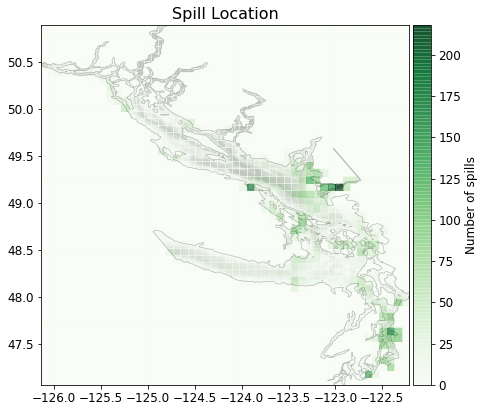

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.pcolormesh(bathy.nav_lon, bathy.nav_lat, bathy.Bathymetry, cmap='Greys', alpha=.1)
ax.contour(bathy.nav_lon, bathy.nav_lat,tmask,alpha=0.05,colors='k',linewidths =.5)
h = ax.hist2d(mcdf.spill_lon, mcdf.spill_lat, alpha=0.7, cmap='Greens', bins=50);
ax.set_aspect(1)
ax.set_title('Spill Location');
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(h[3], cax=cax)
cb.set_label('Number of spills')


## Method 2: Count spills in each grid cell 

In [7]:
# create dataframe to store SSC indices corresponding to spills

In [8]:
#spills_latlon = mcdf[["spill_lon","spill_lat"]].values.tolist()
spills_latlon = mcdf[["spill_lon","spill_lat"]].to_numpy()
# load SSC grid and mask
bathy = xarray.open_dataset(ssc_bathymetry)

In [9]:
spills_latlon.shape

(10000, 2)

In [10]:
grid = nc.Dataset(ssc_bathymetry)
bathy, X, Y = tidetools.get_bathy_data(grid)

In [33]:
print(numpy.min(X),numpy.var(X),numpy.min(Y), numpy.var(Y))

-126.4002914428711 1.1035143895688713 46.85966491699219 1.0863561861713402


In [11]:
bathy.shape

(898, 398)

In [34]:
# initilize arrays for spill count, volume transport vessel and oiltypes
shape = (898, 398)
spill_count = numpy.zeros(shape)
cargo_potential = numpy.zeros(shape)
fuel_potential = numpy.zeros(shape)
vessel_count = {}
oil_count = {}
for vessel in vessel_types:
    vessel_count[vessel] = numpy.zeros(shape)
for oil in oil_types:
    oil_count[oil] = numpy.zeros(shape)
spill_count.shape

(898, 398)

In [35]:
%%time
# create dataframe with grid cell indices for spill location
count=0
for lon,lat in spills_latlon:
    if count<10:
        print(lon,lat)
    y,x = geo_tools.find_closest_model_point(
        lon, lat, X, Y, land_mask = bathy.mask
    )
    spill_count[y,x] += 1
    vesseltype = mcdf["vessel_type"][count]
    oiltype = mcdf["Lagrangian_template"][count]
    cargo_potential[y,x] += mcdf["cargo_capacity"][count]
    fuel_potential[y,x] += mcdf["fuel_capacity"][count]
    vessel_count[vesseltype][y,x] += 1
    oil_count[oiltype][y,x] += 1    
    # add dataframe columns to help suss out important locations more quickly
    mcdf['SSC_X'] = x
    mcdf['SSC_Y'] = y
    mcdf['SSC_XY/Y'] = x*y/y 
    count += 1

-123.62591298421223 49.16803868611654
-123.04898325602214 49.20438766479492
-123.233642578125 49.00887807210287
-125.0351791381836 49.89467875162761
-123.4588139851888 48.87851587931315
-125.72589874267578 50.36818059285482
-125.46514129638672 50.34395599365234
-123.50331370035808 49.120079040527344
-124.59178670247395 49.80628967285156
-122.72906239827472 48.51404571533203
CPU times: user 1min 6s, sys: 818 ms, total: 1min 7s
Wall time: 1min 10s


In [36]:
mcdf.head(1)

,spill_date_hour,run_days,spill_lon,spill_lat,geotiff_x_index,geotiff_y_index,vessel_type,vessel_len,vessel_mmsi,vessel_origin,vessel_dest,fuel_capacity,cargo_capacity,spill_volume,fuel_cargo,Lagrangian_template,SSC_X,SSC_Y,SSC_XY/Y
0,2018-09-10 13:00,7,-123.625913,49.168039,224,516,ferry,134,316001245,NaN,NaN,500000.0,0.0,25000.0,fuel,Diesel,156,262,156.0


In [37]:
test = mcdf[
    ['Lagrangian_template','SSC_X', 'SSC_Y', 'SSC_XY/Y']
].groupby('SSC_XY/Y').count().sort_values(by='Lagrangian_template', ascending=False)

In [38]:
test

,Lagrangian_template,SSC_X,SSC_Y
SSC_XY/Y,,,
156.0,10000,10000,10000


#### spills by oil-type

In [39]:
oil_mask={}
for oil in oil_types:
    #oil_count[oil][oil_count[oil]==0]='nan'
    oil_mask[oil] = numpy.zeros_like(oil_count[oil])
    oil_mask[oil][oil_count[oil]>0]=1
oil_spill_diversity = numpy.zeros_like(oil_count[oil])
print(numpy.min(oil_spill_diversity))
oil_spill_diversity = (oil_mask['ANS']+ oil_mask['Dilbit']+ \
    oil_mask['Bunker-C']+ oil_mask['Diesel']+ \
    oil_mask['Gasoline'] + oil_mask['Jet Fuel']+\
    oil_mask['Other']
)

0.0


In [55]:
numpy.max(oil_spill_diversity)

3.0

### plot up oil spill diversity

These graphics aren't yet turning up as I'd like

In [ ]:
# load SSC grid and mask
bathy = xarray.open_dataset(ssc_bathymetry)
mask = xarray.open_dataset(ssc_mask)

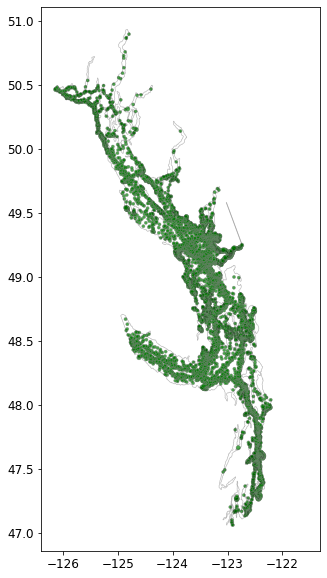

In [46]:
ms = 10
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 10))
ax.contour(bathy.nav_lon, bathy.nav_lat,tmask,alpha=0.05,colors='k',linewidths =.5)
ax.scatter(
    bathy.nav_lon, 
    bathy.nav_lat, 
    s = ms * oil_spill_diversity,
    color='green',
    alpha = 0.7,
    edgecolors='grey',
    linewidth=0.5
)

<ipython-input-47-21e922eed6c3>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h=ax.pcolormesh(


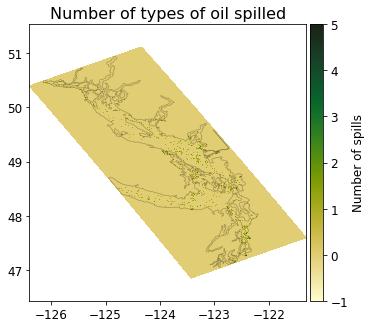

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 10))
ax.contour(bathy.nav_lon, bathy.nav_lat,tmask,alpha=0.05,colors='k',linewidths =.5)
h=ax.pcolormesh(
    bathy.nav_lon, 
    bathy.nav_lat, 
    oil_spill_diversity,
    vmin=-1, 
    vmax=5,
    cmap = cmocean.cm.speed
)
ax.set_aspect(1)
ax.set_title('Number of types of oil spilled');
ax.set_box_aspect(1/1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(h, cax=cax)
cb.set_label('Number of spills')
fig.tight_layout()

ANS


<ipython-input-48-404dc2f4f0b4>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h=ax.pcolormesh(


Bunker-C
Diesel
Gasoline
Jet Fuel
Dilbit
Other


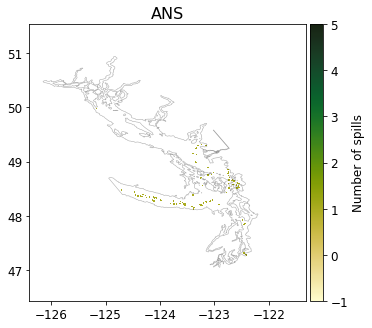

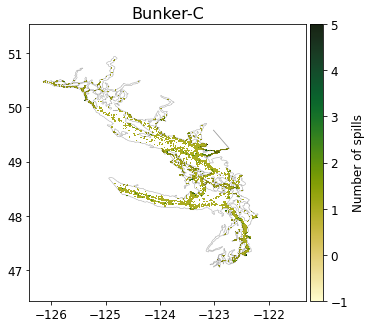

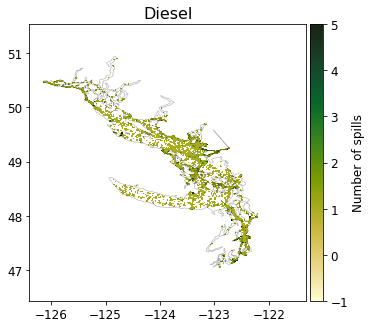

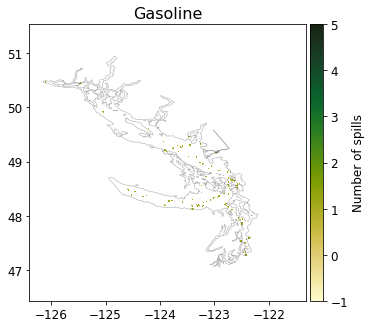

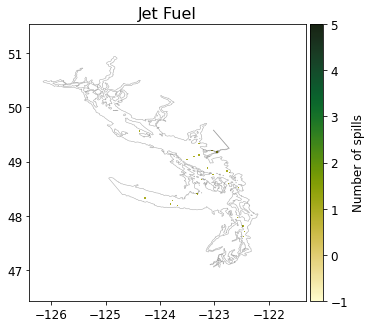

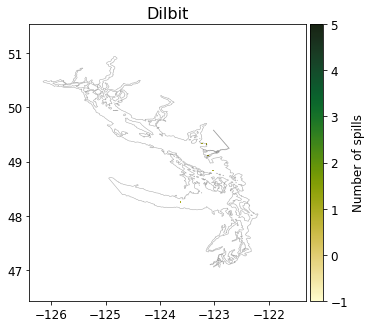

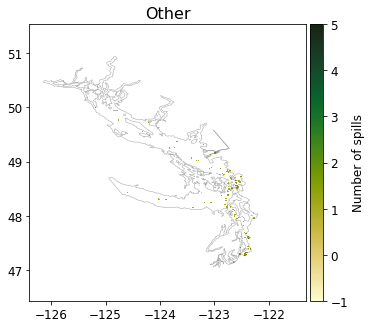

In [48]:
for index,oil in enumerate(oil_types): 
    oil_count[oil][oil_count[oil]==0]='nan'
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 10))
    print(oil)
    ax.contour(bathy.nav_lon, bathy.nav_lat,tmask,alpha=0.05,colors='k',linewidths =.5)
    h=ax.pcolormesh(
        bathy.nav_lon, 
        bathy.nav_lat, 
        oil_count[oil],
        vmin=-1, 
        vmax=5,
        cmap = cmocean.cm.speed
    )
    #ax[index].contour(bathy.nav_lon, bathy.nav_lat,tmask,alpha=0.05,colors='k',linewidths =.5)
    ax.set_aspect(1)
    ax.set_title(oil);
    ax.set_box_aspect(1/1)
#     if index > 0:
#         ax.axes.xaxis.set_visible(False)
#         ax.axes.yaxis.set_visible(False)
#     if index == len(oil_types)-1:
        # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = plt.colorbar(h, cax=cax)
    cb.set_label('Number of spills')
    fig.tight_layout()

ANS


<ipython-input-49-4deabd93c010>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h=ax[index].pcolormesh(


Bunker-C
Diesel
Gasoline
Jet Fuel
Dilbit
Other


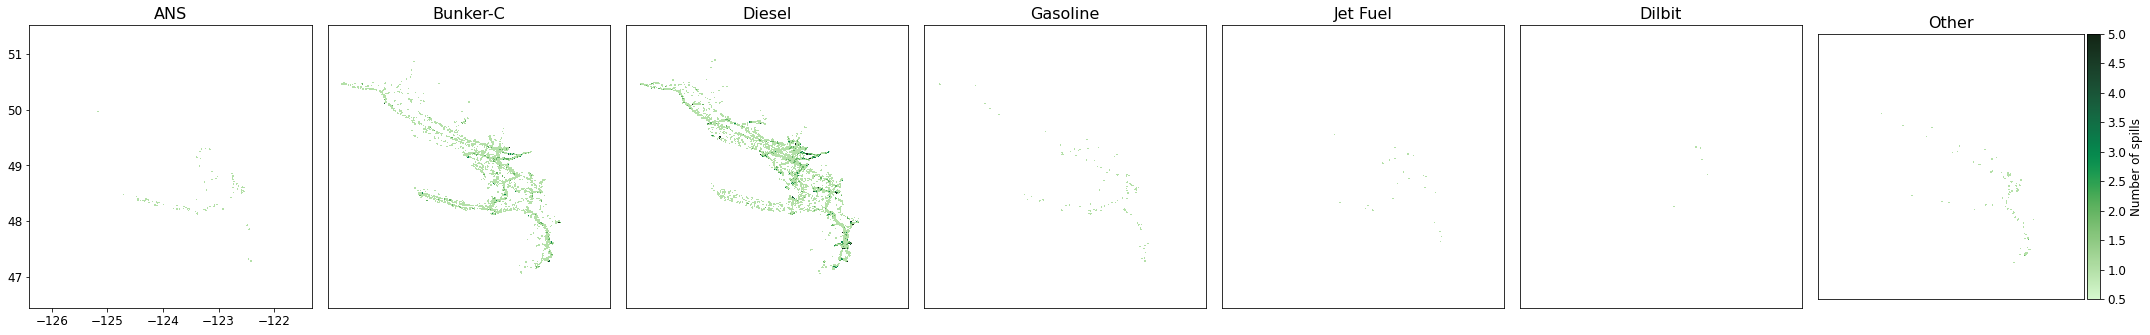

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=len(oil_types), figsize=(30, 30))
for index,oil in enumerate(oil_types): 
    print(oil)
    h=ax[index].pcolormesh(
        bathy.nav_lon, 
        bathy.nav_lat, 
        oil_count[oil],
        vmin=0.5, 
        vmax=5,
        cmap = cmocean.cm.algae
    )
    #ax[index].contour(bathy.nav_lon, bathy.nav_lat,tmask,alpha=0.05,colors='k',linewidths =.5)
    ax[index].set_aspect(1)
    ax[index].set_title(oil);
    ax[index].set_box_aspect(1/1)
    if index > 0:
        ax[index].axes.xaxis.set_visible(False)
        ax[index].axes.yaxis.set_visible(False)
    if index == len(oil_types)-1:
        # create an axes on the right side of ax. The width of cax will be 5%
        # of ax and the padding between cax and ax will be fixed at 0.05 inch.
        divider = make_axes_locatable(ax[index])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cb = plt.colorbar(h, cax=cax)
        cb.set_label('Number of spills')
    fig.tight_layout()

In [50]:
cmocean.cm.speed

In [51]:
fs = 20
ms = 300
fs_legend = 12
fs_legend_title = 16
import matplotlib.gridspec as gridspec

rotated_crs = cartopy.crs.RotatedPole(
    pole_longitude=120.0, pole_latitude=63.75
)
plain_crs = cartopy.crs.PlateCarree()

%matplotlib inline    

fig,axs = plt.subplots(
    1, 1, figsize=(9, 9), 
    subplot_kw={"projection": rotated_crs, "facecolor": "white"}
)

terminal_loc = 0
print('working on first graphic')
axs.add_feature(
    feature.GSHHSFeature('full', edgecolor='k', facecolor='#8b7765'), 
    zorder=1
)

scatter_spills = axs.scatter(
    spills_latlon[:,0], 
    spills_latlon[:,1],
    s = ms * spill_volume_fraction['diesel'],
    color=oil_colors[4],
    transform=plain_crs,
    zorder=2
)
fig.canvas.draw()
plt.show()


working on first graphic


NameError: name 'spill_volume_fraction' is not defined

Error in callback <function flush_figures at 0x13e3a11f0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
level1 = [list(row) for row in spills_latlon]

In [ ]:
level1[:,1]

In [ ]:
import itertools
out = list(itertools.chain(*spills_latlon))
out